In [1]:
%pylab inline

from pyotf.utils import easy_fft, easy_ifft

Populating the interactive namespace from numpy and matplotlib


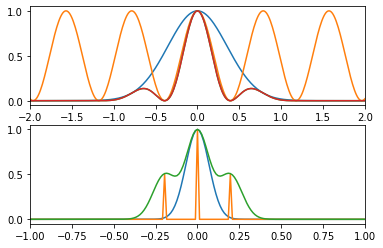

In [6]:
fig, (ax_real, ax_freq) = plt.subplots(2)
x = (np.arange(1024) - 512) * 2 * pi / 512
g = exp(-(x)**2 * 4)
s = (cos(x * 8) + 1)/2
ax_real.plot(x, g)
ax_real.plot(x, s)
ax_real.set_xlim(-2, 2)

ax_freq.plot(x, abs(easy_fft(g / g.sum())))
ax_freq.plot(x, abs(easy_fft(s / s.sum())))
ax_freq.set_xlim(-1, 1)

sg = s * g


ax_real.plot(x, sg)
ax_freq.plot(x, abs(easy_fft(sg / sg.sum())))

sgi1 = abs(easy_ifft(abs(easy_fft(sg))))


ax_real.plot(x, sgi1)

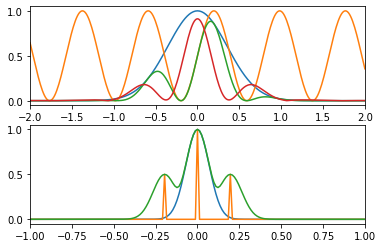

In [7]:
fig, (ax_real, ax_freq) = plt.subplots(2)
x = (np.arange(1024) - 512) * 2 * pi / 512
g = exp(-(x)**2 * 4)
s = (sin(x * 8) + 1)/2
ax_real.plot(x, g)
ax_real.plot(x, s)
ax_real.set_xlim(-2, 2)

ax_freq.plot(x, abs(easy_fft(g / g.sum())))
ax_freq.plot(x, abs(easy_fft(s / s.sum())))
ax_freq.set_xlim(-1, 1)

sg = s * g


ax_real.plot(x, sg)
ax_freq.plot(x, abs(easy_fft(sg / sg.sum())))

sgi2 = abs(easy_ifft(abs(easy_fft(sg))))


ax_real.plot(x, sgi2)

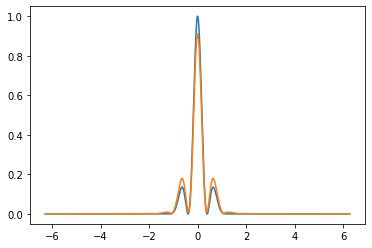

In [8]:
plt.plot(x, sgi1)
plt.plot(x, sgi2)

/Users/david/miniconda3/envs/sandbox/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


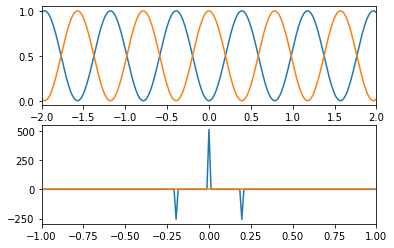

In [9]:
fig, (ax_real, ax_freq) = plt.subplots(2)
x = (np.arange(1024) - 512) * 2 * pi / 512
s = (sin(x * 8 + 3*pi/2) + 1)/2
ax_real.plot(x, s)
ax_real.set_xlim(-2, 2)

fs = easy_fft(s)
ax_freq.plot(x, fs.real)
ax_freq.plot(x, fs.imag)
ax_freq.set_xlim(-1, 1)

ffs = easy_ifft(abs(fs))
ax_real.plot(x, ffs)

/Users/david/miniconda3/envs/sandbox/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


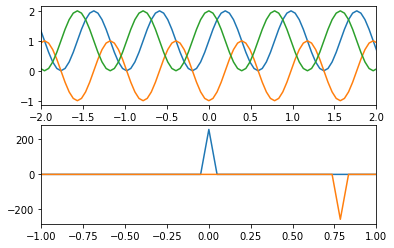

In [46]:
fig, (ax_real, ax_freq) = plt.subplots(2)
x = (np.arange(256) - 128) * 2 * pi / 128
s = exp(1j*(x * 8 + 3*pi/2)) + 1
ax_real.plot(x, s.real)
ax_real.plot(x, s.imag)
ax_real.set_xlim(-2, 2)

fs = easy_fft(s)
ax_freq.plot(x, fs.real)
ax_freq.plot(x, fs.imag)
ax_freq.set_xlim(-1, 1)

ffs = easy_ifft(abs(fs))
ax_real.plot(x, ffs)

In [47]:
xx, yy = meshgrid(x, x)

In [65]:

s = np.zeros_like(xx * 1j)
for theta in (-pi/4, 0, pi/4):
    s += exp(1j*((xx*cos(theta) + yy*sin(theta)) * 20))

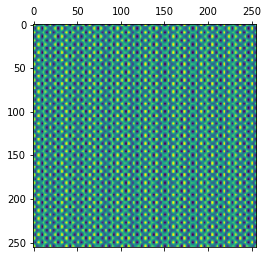

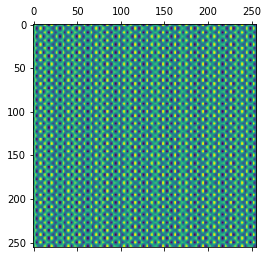

In [66]:
matshow(s.real)
matshow(s.imag)

In [75]:
ss = abs(easy_fft(abs(s)**2))

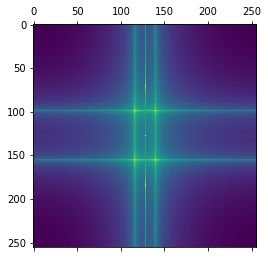

In [77]:
matshow(ss, norm=mpl.colors.LogNorm())

In [52]:
ss.max()

(65536+1.2540383223268897e-12j)